In [ ]:
%%capture
!pip3 install --pre dgl -f https://data.dgl.ai/wheels/cu117/repo.html
!pip3  install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip3 install alignn
## Capture at the begining of thr cell supresses output. Remove it if you want to see what is happenning under the hood or run into errors.

### Optimizing 2D monolayers using ALIGNNFF

In [ ]:
# Using the Atomistic LIne Graph Neural Network force-field for relaxation of 2D materials. 
# References:
# https://pubs.rsc.org/en/content/articlepdf/2023/dd/d2dd00096b 
# https://www.nature.com/articles/s41524-021-00650-1
# https://github.com/usnistgov/alignn
# https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Training_ALIGNN_model_example.ipynb#scrollTo=6KLHCj7Aujmt
# https://gist.github.com/jkitchin/e8ab20750b1d516cb8761f519f2c53d5
# https://cmr.fysik.dtu.dk/c2db/c2db.html#id13

The ALIGNN-FF model developed by NIST was trained on more than 307133 data points from the JARVIS dataset. To test its performance on 2D materials, I will try to relax some of the structures included in the C2DB database for 2D materials. The ALIGNN-FF model easily interfaces with ASE allowing for a great deal of functionality and facilates its usage. First, we will create POSCAR files for about 15K 2D materials avaialble in the database. The details of how the structure were generated can be found in the following paper.

https://arxiv.org/pdf/2206.12159.pdf

### Creating POSCAR files from C2DB

In [ ]:
from ase.io import read, write
from os.path import join
import concurrent.futures
import sqlite3
import pandas as pd
# Connect to the SQLite database
conn = sqlite3.connect('C2DB.db')

# Replace 'your_table_name' with the actual name of the table you want to load
table_name = 'systems'

# Define the SQL query to select all rows from the table
sql_query = f"SELECT * FROM {table_name}"

# Execute the SQL query and load the result into a DataFrame
df = pd.read_sql_query(sql_query, conn)

# Close the connection
conn.close()

# Print the DataFrame
id_list = df.id.to_list()

def wrapped_write_poscar_from_id(id):
    write_poscar_from_id(id, db_path='c2db.db', output_path='POSCARS')

# Use ThreadPoolExecutor to apply the wrapped function to each element in the id list
with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(wrapped_write_poscar_from_id, id_list)
def write_poscar_from_id(id:str, db_path:str, output_path:str):
    atoms = read('{}@id={}'.format(db_path,id))
    file_name = '{}.vasp'.format(id)
    file_path = join(output_path,file_name)
    write(file_path,atoms,format='vasp',direct = True)

### Creating a function to relax a 2D structure by applying compressive and tensile strain in the xy plane and then fitting an equation of states to determine optimal lattice parameters

In [ ]:

import os
from ase import Atoms
from ase.io import read, write
from ase.units import eV, Ang
from ase.eos import EquationOfState
import numpy as np
import matplotlib.pyplot as plt
from alignn.ff.ff import AlignnAtomwiseCalculator, default_path
%matplotlib inline

model_path = default_path()
calc = AlignnAtomwiseCalculator(path=model_path)


def optimize_structure(input_file, show_plot=True, lower=0.9, upper=1.1, npoints=50):
    atoms = read(input_file, format='vasp')
    atoms.calc = calc
    volumes = []
    energies = []
    cells = []
    scaling_factors = np.linspace(lower, upper, npoints)
    original_cell = atoms.get_cell().copy()

    for s in scaling_factors:
        scaled_cell = original_cell.copy()
        scaled_cell[0, :] *= s
        scaled_cell[1, :] *= s
        scaled_atoms = Atoms(symbols=atoms.get_chemical_symbols(),
                             scaled_positions=atoms.get_scaled_positions(),
                             cell=scaled_cell,
                             pbc=atoms.get_pbc())
        scaled_atoms.calc = calc
        volume = scaled_atoms.get_volume()
        energy = scaled_atoms.get_potential_energy()
        volumes.append(volume)
        energies.append(energy)
        cells.append(scaled_cell.copy())

    eos = EquationOfState(volumes, energies)
    try_count = 1
    while try_count <= 10:
        try:
            v0, e0, B = eos.fit()
            break
        except ValueError:
            if try_count < 10:
                upper += 0.1
                npoints += 10
                scaling_factors = np.linspace(lower, upper, npoints)
                volumes = []
                energies = []
                cells = []
                original_cell = atoms.get_cell().copy()
                for s in scaling_factors:
                    scaled_cell = original_cell.copy()
                    scaled_cell[0, :] *= s
                    scaled_cell[1, :] *= s
                    scaled_atoms = Atoms(symbols=atoms.get_chemical_symbols(),
                                         scaled_positions=atoms.get_scaled_positions(),
                                         cell=scaled_cell,
                                         pbc=atoms.get_pbc())
                    scaled_atoms.calc = calc
                    volume = scaled_atoms.get_volume()
                    energy = scaled_atoms.get_potential_energy()
                    volumes.append(volume)
                    energies.append(energy)
                    cells.append(scaled_cell.copy())
                eos = EquationOfState(volumes, energies)
                print(f"ValueError: Could not find a minimum after {try_count} trials. Trying over a larger range")
            else:
                print("Error: Could not find a minimum after 10 trials. Terminating the optimization.")
                return None
            try_count += 1

    index = np.argmin(np.abs(np.array(volumes) - v0))
    optimal_cell = cells[index]
    atoms.set_cell(optimal_cell, scale_atoms=True)
    output_file = os.path.splitext(input_file)[0] + "--optim" + os.path.splitext(input_file)[1]
    write(output_file, atoms, format='vasp', direct=True)

    if show_plot:
        plt.figure()
        eos.plot()
        plt.axvline(v0, linestyle='--', label='optimal volume', color='gray')
        plt.xlabel(r'Volume (Å$^3$)')
        plt.ylabel('Total Energy (eV)')
        plt.title('Total Energy vs. Volume')
        plt.legend(['EOS fit', 'ALIGNN predictions', 'Optimized volume'])
        plt.show()

def print_file_contents(file_path):
    try:
        with open(file_path, 'r') as file:
            contents = file.read()
            print(contents)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"Error: {e}")

model_path /usr/local/lib/python3.9/site-packages/alignn/ff


### Performance of the pretrained neural network

The neural network performs remarkeably well on the dataset. And the predicted lattice parameters are typically within 0.2 angstroms. And relaxation takes less than a one minute regardelss of the size of the POSCAR and how many atoms exist!

The cells below show some examples of some randomly chosen examples

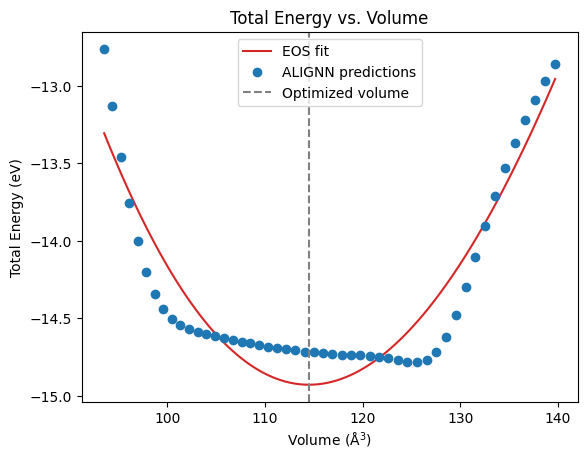

**************** Relaxed structure from DFT ****************
Fe  O 
 1.0000000000000000
     2.8101902070595157    0.0000000000000000    0.0000000000000000
    -1.4050951035297579    2.4336961087797921    0.0000000000000000
     0.0000000000000000    0.0000000000000000   16.8845743086877498
 Fe  O  
   1   2
Direct
  0.0000000000000000  0.0000000000000000  0.4999999992048025
  0.6666666666666666  0.3333333333333333  0.5589054882815312
  0.3333333333333332  0.6666666666666665  0.4410945094829772

**************** Relaxed structure from ALIGNNFF ****************
Fe  O 
 1.0000000000000000
     2.7929849608938455    0.0000000000000000    0.0000000000000000
    -1.3964924804469228    2.4187959285219569    0.0000000000000000
     0.0000000000000000    0.0000000000000000   16.8845743086877498
 Fe  O  
   1   2
Direct
  0.0000000000000000  0.0000000000000000  0.4999999992048025
  0.6666666666666666  0.3333333333333334  0.5589054882815313
  0.3333333333333333  0.6666666666666666  0.44109450948

In [ ]:
optimize_structure('POSCARS/3000.vasp', show_plot=True)
print('**************** Relaxed structure from DFT ****************')
print_file_contents('POSCARS/3000.vasp')
print('**************** Relaxed structure from ALIGNNFF ****************')
print_file_contents('POSCARS/3000--optim.vasp')

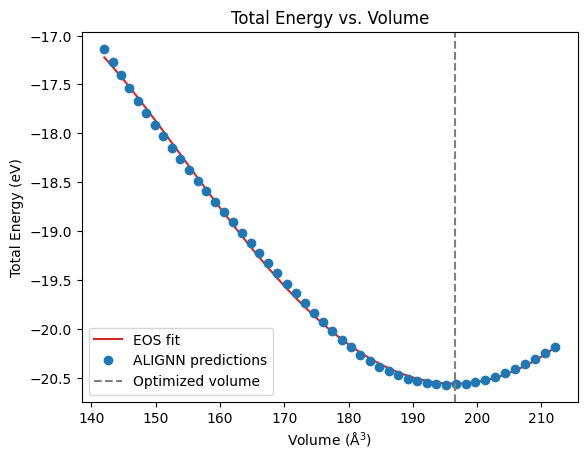

**************** Relaxed structure from DFT ****************
Mo Se Mo 
 1.0000000000000000
     3.1260264983536370   -0.0000000000000000    0.0000000000000000
    -1.5630132491768185    2.7061601831598758    0.0000000000000000
     0.0000000000000000    0.0000000000000000   20.7245717374476044
 Mo  Se  Mo 
   1   2   1
Direct
  0.5000521528087124  0.5027687069064350  0.5539248948416730
  0.4995399227822368  0.4963355214509212  0.3619327434043841
  0.1666521173072079 -0.1639461768219526  0.6380671819453430
  0.1661153517900831  0.8295634229582375  0.4460750242131047

**************** Relaxed structure from ALIGNNFF ****************
Mo Se Mo 
 1.0000000000000000
     3.3110362298888525   -0.0000000000000000    0.0000000000000000
    -1.6555181149444262    2.8663206837958688    0.0000000000000000
     0.0000000000000000    0.0000000000000000   20.7245717374476044
 Mo  Se  Mo 
   1   2   1
Direct
  0.5000521528087123  0.5027687069064349  0.5539248948416730
  0.4995399227822368  0.496335521

In [ ]:
optimize_structure('POSCARS/14501.vasp', show_plot=True)
print('**************** Relaxed structure from DFT ****************')
print_file_contents('POSCARS/14501.vasp')
print('**************** Relaxed structure from ALIGNNFF ****************')
print_file_contents('POSCARS/14501--optim.vasp')


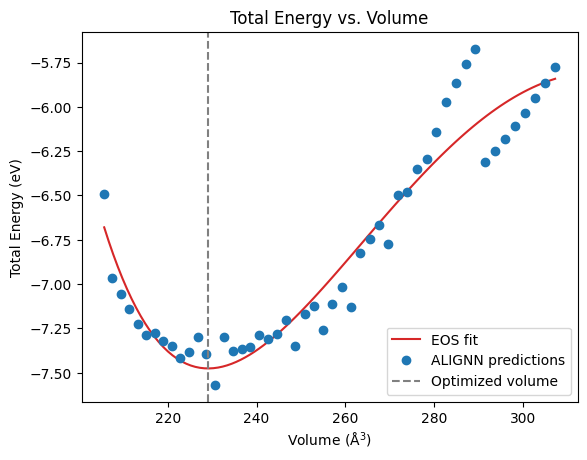

**************** Relaxed structure from DFT ****************
Cl Pt 
 1.0000000000000000
     3.7182352981628872    0.0000000000000000    0.0000000000000000
     0.0000000000000002    3.7182352981628872    0.0000000000000000
    -0.0000000000000000    0.0000000000000000   18.3658282784479674
 Cl  Pt 
   2   2
Direct
  0.0000000000000002  0.0000000000000003  0.6083847588322217
  0.5000000000000000  0.5000000000000001  0.3916152451945153
  0.5000000000000002  0.0000000000000002  0.5000000013129448
  0.0000000000000002  0.5000000000000002  0.5000000013129448

**************** Relaxed structure from ALIGNNFF ****************
Cl Pt 
 1.0000000000000000
     3.5285294156035563    0.0000000000000000    0.0000000000000000
     0.0000000000000002    3.5285294156035563    0.0000000000000000
    -0.0000000000000000    0.0000000000000000   18.3658282784479674
 Cl  Pt 
   2   2
Direct
  0.0000000000000002  0.0000000000000003  0.6083847588322215
  0.4999999999999999  0.5000000000000001  0.39161524519

In [ ]:
optimize_structure('POSCARS/2943.vasp', show_plot=True)
print('**************** Relaxed structure from DFT ****************')
print_file_contents('POSCARS/2943.vasp')
print('**************** Relaxed structure from ALIGNNFF ****************')
print_file_contents('POSCARS/2943--optim.vasp')

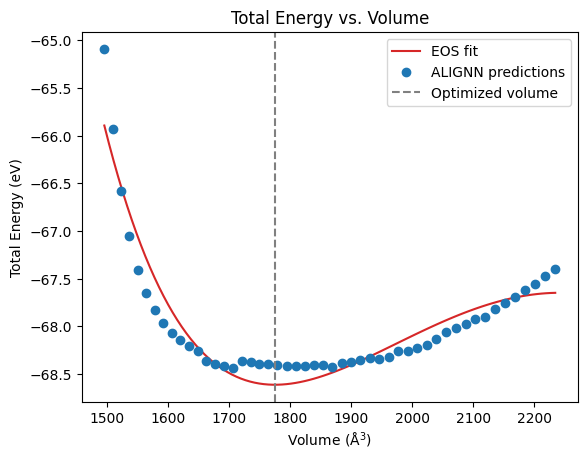

**************** Relaxed structure from DFT ****************
Nb Co Se 
 1.0000000000000000
     3.4262622720418072    0.0000000000000000    0.0000000000000000
    -0.0000000000000001   15.8223283064526203    0.0000000000000000
    -0.0000000000000000    0.0000000000000000   34.0611365600000013
 Nb  Co  Se 
   4   2  10
Direct
  0.0000000000000000 -0.0013436987348336  0.4908750245475658
 -0.0000000000000000  0.7189230810994345  0.4908750599965546
  0.4999999999999970  0.2189230810994414  0.5091249400034457
  0.4999999999999970  0.4986563012651649  0.5091249754524344
  0.0000000000000000  0.3587896113263087  0.5161558568449374
  0.4999999999999970  0.8587896113263109  0.4838441431550630
  0.4999999999999970  0.9661714765607188  0.4364341181271098
  0.4999999999999970  0.7514077833678943  0.4364341349641040
  0.0000000000000000  0.2514077833679050  0.5635658650358916
 -0.0000000000000000  0.4661714765607208  0.5635658818728899
 -0.0000000000000000  0.1539524311100487  0.4586398854562814
 

In [ ]:
optimize_structure('POSCARS/435.vasp', show_plot=True)
print('**************** Relaxed structure from DFT ****************')
print_file_contents('POSCARS/435.vasp')
print('**************** Relaxed structure from ALIGNNFF ****************')
print_file_contents('POSCARS/435--optim.vasp')

It seems like this neural network already achieves near ab initio accuracy. I will try to retrain the model on the C2DB to try to improve it to reach ab initio accuracy.